In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pyportopt as opt
from pyportbt import PyBacktest
import pyportstats as stats

In [3]:
from pandas_datareader import data

In [4]:
"""Define parameters for data request."""

tickers = ['AGG', 'EBND', 'URTH', 'EEM']
data_source = 'yahoo'
start_date = '2014-03-31'
end_date = '2018-03-31'

In [5]:
"""Request data, ensure sorted by ascending date, and normalise."""

panel_data = data.DataReader(tickers, data_source, start_date, end_date)
px_data = panel_data.loc['Adj Close'].dropna().sort_index(ascending=True)
px_data = px_data / px_data.iloc[0]

In [35]:
"""
TEST CASE
Add constraints: Portfolio weights must sum to 100%, minimum ann. return > 3.0%,
Add boundaries: Long only, no short positions.
"""

vol_trgt = 0.05

cons = (
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    {'type': 'eq', 'fun': lambda w: opt.summary_stats(w, px_data)['volatility'] - vol_trgt}
)

bnds = tuple((0, 1) for x in px_data.columns)

In [36]:
"""Run optimisation."""

opt_result = opt.port_optimisation(opt.max_sr, px_data, rf=0.0, scaling_fact=252, constraints=cons, bounds=bnds)

Optimization terminated successfully. Success==True after 5 iterations.
Total time: 0.17821717262268066 secs


In [37]:
"""View optimised weights."""

opt_result['weights']

array([  6.34927578e-01,   3.99644968e-17,   1.01612190e-18,
         3.65072422e-01])

In [38]:
"""Initialise backtest class."""


rf = 0.0
bt = PyBacktest(px_data, opt_period = 365, val_period = 90, rf=rf, scaling_fact=252)

In [39]:
"""Generate historical optimisation weights."""

max_er = bt.bt_optimisation(opt.max_er, constraints=cons, bounds=bnds)
max_er_ts = bt.bt_timeseries()

min_vol = bt.bt_optimisation(opt.min_vol, constraints=cons, bounds=bnds)
min_vol_ts = bt.bt_timeseries()

max_sr = bt.bt_optimisation(opt.max_sr, constraints=cons, bounds=bnds)
max_sr_ts = bt.bt_timeseries()

risk_parity = bt.bt_optimisation(opt.risk_parity, constraints=cons, bounds=bnds)
risk_parity_ts = bt.bt_timeseries()

max_dr = bt.bt_optimisation(opt.max_dr, constraints=cons, bounds=bnds)
max_dr_ts = bt.bt_timeseries()

Total time: 2.9016122817993164 secs
Total time: 3.8579916954040527 secs
Total time: 2.0991604328155518 secs
Total time: 2.785167694091797 secs
Total time: 2.8059957027435303 secs


In [40]:
"""Create df of individual results."""

comp_df = pd.concat([max_er_ts.MV, min_vol_ts.MV, max_sr_ts.MV, risk_parity_ts.MV, max_dr_ts.MV], axis=1)
comp_df.columns = ['max_er', 'min_vol', 'max_sr', 'risk_parity', 'max_dr']

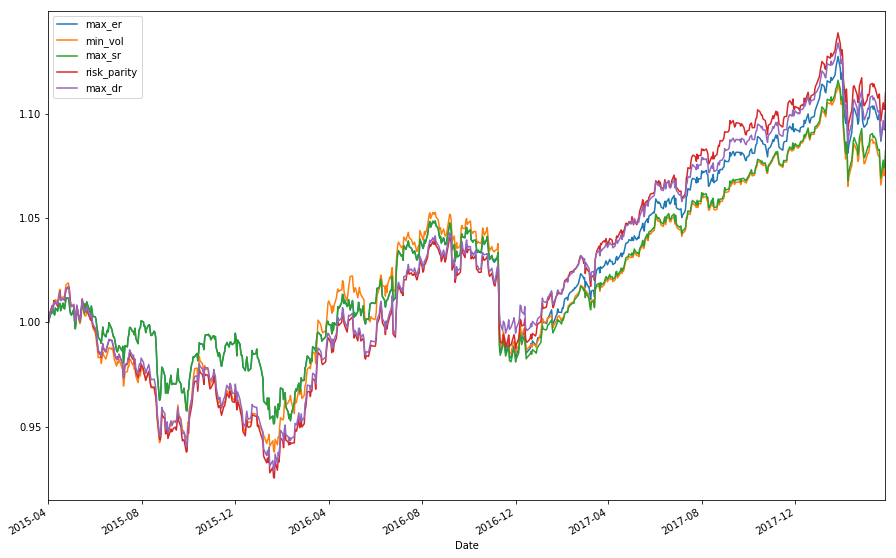

In [41]:
"""Plot and compare optimisation results."""

comp_df.plot(figsize=(15,10))
plt.legend(loc='best');

In [42]:
"""View summary statistics."""

stats.stats_summary(comp_df, rf=rf)

,max_er,min_vol,max_sr,risk_parity,max_dr
cumu_return,0.100276,0.078515,0.082225,0.110133,0.101290
ann_return,0.032426,0.025562,0.026739,0.035506,0.032744
volatility,0.053541,0.051222,0.053575,0.051202,0.050703
sharpe_ratio,0.605639,0.499047,0.499096,0.693447,0.645805
max_drawdown,-0.062825,-0.079715,-0.064542,-0.090033,-0.086990
